# Little Rock to Chicago
This notebook creates a route from the LA/Long beach ports to Chicago using UP owned tracks.

In [1]:
import geopandas as gpd
import networkx as nx
from shapely import geometry, ops
import numpy as np
import matplotlib.pyplot as plt
import requests
import pandas as pd
import folium
import time
from requests.auth import AuthBase
import os
from scipy.spatial import distance

In [2]:
URL ="http://score-web-1:8000"
URL1 = URL+"/api-token-auth/"
payload = {'username':'locomotives', 'password':'locomotives'}
URL2 = URL+"/api/line/add/"
URL3 = URL+'/api/railroad/'
URL4 = URL + "/api/line/"
URL5 = URL + "/api/route/add/"
URL6 = URL + "/api/yard/all/"
URL7 = URL + "/api/yard/"
URL8 = URL + "/api/route/detail/"
URL9 = URL + "/api/route/elevations/update/"
URL10 = URL + "/api/yard/add/"

In [3]:
t = requests.post(URL1, data=payload )
token = t.json().get('token')

In [4]:
class TokenAuth(AuthBase):
    """ Implements a custom authentication scheme. """

    def __init__(self, token):
        self.token = token

    def __call__(self, r):
        """ Attach an API token to a custom auth header. """
        r.headers['Authorization'] = "Token " + f'{self.token}'
        return r

In [5]:
r = requests.get(URL3, auth=TokenAuth(token))
railroads=r.json()['results']
railroads

[{'id': 1, 'code': 'BNSF', 'name': 'Burlington Northern and Santa Fe'},
 {'id': 2, 'code': 'CN', 'name': 'Canadian National Railway'},
 {'id': 3, 'code': 'CP', 'name': 'Canadian Pacific Railway'},
 {'id': 4, 'code': 'CSXT', 'name': 'CSX Transportation'},
 {'id': 5, 'code': 'NS', 'name': 'Norfolk Southern Railway'},
 {'id': 6, 'code': 'KCS', 'name': 'Kansas City Southern Railway'},
 {'id': 7, 'code': 'UP', 'name': 'Union Pacific'}]

In [6]:
response = requests.get(URL6, auth=TokenAuth(token))
yards = response.json()['results']
yards

[{'id': 2, 'name': 'Rickenbacker'},
 {'id': 4, 'name': 'Norfolk'},
 {'id': 6, 'name': 'Savannah'},
 {'id': 7, 'name': 'Macon'},
 {'id': 8, 'name': 'Tyrone'},
 {'id': 9, 'name': 'State College'},
 {'id': 5, 'name': 'Suffolk'},
 {'id': 1, 'name': 'Landers Yard'},
 {'id': 14, 'name': 'Maple Heights Intermodal'},
 {'id': 11, 'name': 'Bethlehem Intermodal'},
 {'id': 13, 'name': 'Pitcairn Intermodal'},
 {'id': 12, 'name': 'Rutherford Intermodal'},
 {'id': 15, 'name': '47th Street Intermodal'},
 {'id': 10, 'name': 'Croxton'},
 {'id': 16, 'name': 'Hobart Yard'},
 {'id': 17, 'name': 'Cicero Yard'},
 {'id': 19, 'name': 'North Little Rock Yard'},
 {'id': 18, 'name': 'UP Global II'}]

We need to start by adding "yards" for Little Rock and Chicago. We want to select yards that are owned by UP.

In [7]:
response = requests.get(URL7+'19', auth=TokenAuth(token))
start = response.json()['results']
start

{'id': 19,
 'code': 'NLR',
 'name': 'North Little Rock Yard',
 'city': 'Little Rock',
 'state': 'AR',
 'location': 385995,
 'owner': 7}

End the route at UP Global 2 in Chicago.

In [8]:
response = requests.get(URL7+'18', auth=TokenAuth(token))
end = response.json()['results']
end

{'id': 18,
 'code': 'GB2',
 'name': 'UP Global II',
 'city': 'Chicago',
 'state': 'IL',
 'location': 412385,
 'owner': 7}

The next step is to read in the NARN database.

In [9]:
data = gpd.read_file("North_American_Rail_Network_Lines.geojson")

To simplify things a bit, we will only include BNSF tracks.

In [10]:
up_data = data[data[['rrowner1', 'rrowner2', 'rrowner3', 'trkrghts1', 'trkrghts2', 'trkrghts3', 'trkrghts4', 'trkrghts5', 'trkrghts6', 'trkrghts7', 'trkrghts8', 'trkrghts9']].isin(['UP']).any(axis=1)]
#bnsf_data = data

## Determine the shortest route
We use the networkx library to determine the "optimal" route between two nodes on a graph. For this optimization, the graph consists of all nodes and "edges" or lines for which UP owns or has rights. This was determined above.

In [11]:
from_nodes = list(up_data.frfranode)

In [12]:
to_nodes = list(up_data.tofranode)

The nodes in the graph is a union of all of the to and from nodes in the dataset.

In [13]:
all_nodes = list(set(from_nodes) | set(to_nodes))

The next step is to actually create a graph.

In [14]:
G=nx.Graph()

In [15]:
G.add_nodes_from(all_nodes)

We need to add the edges between the nodes and give them a weighting of the distance between the nodes - this will result in the shortest route.

In [16]:
edges = up_data[['frfranode','tofranode', 'miles']].to_records(index=False).tolist()

In [17]:
G.add_weighted_edges_from(edges)

In [18]:
start_node = start['location']
end_node = end['location']

In [19]:
route = nx.astar_path(G, start_node, end_node)

In [20]:
route_data = up_data[(up_data['frfranode'].isin(route) & up_data['tofranode'].isin(route))]

In [21]:
fig = folium.Figure(height=600)
map = folium.Map(location=[40.75, -85.0], zoom_start=10,tile=None)
folium.TileLayer(tiles='http://{s}.tiles.openrailwaymap.org/standard/{z}/{x}/{y}.png', attr='OpenStreetMap attribution').add_to(map)
folium.TileLayer(tiles='http://{s}.google.com/vt/lyrs=s,h&x={x}&y={y}&z={z}', attr='Google Maps').add_to(map)
folium.GeoJson(route_data).add_to(map)
map.add_to(fig)

Let's see how many segments there are along the route.

In [22]:
len(route_data)

398

In each of these segments are a number of locations. The original database does not do a great job of spacing them out, so we need to take a few steps to correct this for our application. The simplify function reduces the number of locations to specify a curve while maintaining a minum error from the original (1 meter in this case). The conversion to 3857 converts the locations from lat,longs to x,y meters.

In [23]:
route_data = route_data.to_crs(3857)
simple_route = route_data.simplify(1, preserve_topology=False)
len(simple_route.geometry.get_coordinates())

3800

To better support the estimation of gradient (and may also assist in curvature), we should segmentize the data to have a maximum distance between points. This can add significantly to the number of locations again, but does help to regularize the data for the LTD.

In [24]:
simple2_route = simple_route.segmentize(max_segment_length=200)
simple2_route = simple2_route.to_crs(4326)
len(simple2_route.geometry.get_coordinates())

8870

In [25]:
def curve(p1, p2, p3):
    v1=p2-p1
    v2=p3-p2
    v3=p1-p3
    d1=np.linalg.norm(v1)
    d2=np.linalg.norm(v2)
    d3=np.linalg.norm(v3)
    num = 1746.375*2*np.linalg.norm(np.cross(v1,v2))
    d = num/(d1*d2*d3)
    if d<0.01:
        d=0.0
    return d

In [26]:
route_xy = route_data.copy()

In [27]:
route_ll = route_data.to_crs(4326)

In [28]:
API_KEY=

This function sends a number of locations to the Google elevation Rest API at once and gets the results. 

In [29]:
def get_alt(lat, lng):
    st = ""
    # print(lng)
    for i in range(len(lng)):
        st+=str(lat[i])+','+str(lng[i])+'|'
    st=st[:-1]
    url = "https://maps.googleapis.com/maps/api/elevation/json?locations=" + st + "&key=" + API_KEY
    # print(url)
    response = requests.get(url)
    # result = response.json()['results']['elevation']
    # print(response.status)
    # print(response.json()['results'])
    results = response.json()['results']
    res = []
    for rec in results:
        res.append(rec['elevation'])
    # should put in a test for response status before returning an actual value
    return res

We need to explode the multilinestrings that are being used in the NARN database to be linestrings

In [30]:
route_xy.geometry=simple2_route.to_crs(3857)
route_xy2 = route_xy.explode(index_parts=True)

In [31]:
np.array(route_xy2.iloc[0].geometry.coords)

array([[-10099395.60228267,   4571241.36969976],
       [-10099446.94951099,   4571078.62866057],
       [-10099498.29673931,   4570915.88762139],
       [-10099549.64396763,   4570753.1465822 ],
       [-10099600.99119595,   4570590.40554301]])

In [32]:
route_ll.geometry=simple2_route
route_ll2 = route_ll.explode(index_parts=True)
np.array(route_ll2.iloc[0].geometry.coords)

array([[-90.7244143 ,  37.94204091],
       [-90.72487556,  37.94088798],
       [-90.72533682,  37.93973502],
       [-90.72579808,  37.93858205],
       [-90.72625934,  37.93742907]])

This routine creates a line segment for the database that mirrors line segments in the NARN database

In [33]:
def create_row(rowxy, rowll, rights, url, token=None):
    p = np.array(rowxy.geometry.coords)
    pxy = p[:,0:2]
    # we want the interpoint distance between the points - the offset of 1, diagonal of the cdist matrix
    dist = np.diagonal(distance.cdist(pxy, pxy), offset=1)
    lng,lat = rowll.geometry.xy
    ele=get_alt(lat, lng)
    lnglat = np.array(rowll.geometry.coords)
    dele = np.diff(ele)
    gradient = np.divide(dele, dist)
    curvature=[]
    if (len(pxy)>2):
        for i in range(len(pxy)-2):
            curvature.append(curve(pxy[i],pxy[i+1],pxy[i+2]))
        curvature.append(curvature[-1])
    else:
        curvature = [0.0]
    line = {
        "fra_id" : rowxy['fraarcid'],
        "from_node" : rowxy['frfranode'],
        "to_node" : rowxy['tofranode'],
        "length" :dist.sum(),
        "rights" : rights,
        "net": rowxy['net'],
        "xy": pxy.tolist(),
        "elevation": ele,
        "lnglat": lnglat.tolist(),
        "gradient": gradient.tolist(),
        "curvature": curvature,
        "distance":dist.tolist()
    }
    requests.post(url, data=line, auth=TokenAuth(token))
    print(line['fra_id'])
        

Lets test just one for now

In [34]:
create_row(route_xy2.iloc[0], route_ll2.iloc[0], [1], URL2, token)

346067


That works so lets do them all.

In [35]:
for i in range(len(route_xy2)):
    # first test to see if it already exists
    fra_id = route_xy2.iloc[i]['fraarcid']
    response = requests.get(URL4+str(fra_id), auth=TokenAuth(token))
    # if (response.status_code == 204):
    create_row(route_xy2.iloc[i], route_ll2.iloc[i], [1], URL2, token)
    # print(route2_xy2.iloc[i][['fraarcid','frfranode', 'tofranode','net','miles']]) 

346067
346524
346958
347119
347120
347663
347847
347955
347963
348039
348210
348311
348442
348640
348678
348756
348906
349090
349429
349635
349853
349861
349901
349973
350802
351332
351410
351507
351772
352008
352129
352307
352418
352464
352465
352640
352834
352843
353101
353492
353507
353550
353948
354200
354404
354420
354421
354635
354743
354750
354821
354859
354978
355164
355205
355711
356041
356148
356163
356168
356174
356614
356618
356969
357074
357138
357291
357520
357525
357529
357716
357750
357964
358062
358130
358460
358565
358793
359146
359260
359416
359594
359641
359701
359853
360160
360329
360606
360660
360695
360886
361106
361292
361813
361814
362072
362717
362776
362977
362997
363036
363078
363128
363153
363157
363355
363646
363826
363896
364147
364201
364537
364687
364912
365378
365530
365543
365609
365725
365765
366193
366488
366626
366633
366930
366952
367242
367262
367406
367502
367655
367713
367853
367878
368067
368122
368472
368581
368594
368730
368765
368885
369053

The next step to saving a route is to include an  ordered list of nodes used make the route.

In [36]:
len(route_xy2)

398

In [37]:
response = requests.get(URL6, auth=TokenAuth(token))
response.json()

{'results': [{'id': 2, 'name': 'Rickenbacker'},
  {'id': 4, 'name': 'Norfolk'},
  {'id': 6, 'name': 'Savannah'},
  {'id': 7, 'name': 'Macon'},
  {'id': 8, 'name': 'Tyrone'},
  {'id': 9, 'name': 'State College'},
  {'id': 5, 'name': 'Suffolk'},
  {'id': 1, 'name': 'Landers Yard'},
  {'id': 14, 'name': 'Maple Heights Intermodal'},
  {'id': 11, 'name': 'Bethlehem Intermodal'},
  {'id': 13, 'name': 'Pitcairn Intermodal'},
  {'id': 12, 'name': 'Rutherford Intermodal'},
  {'id': 15, 'name': '47th Street Intermodal'},
  {'id': 10, 'name': 'Croxton'},
  {'id': 16, 'name': 'Hobart Yard'},
  {'id': 17, 'name': 'Cicero Yard'},
  {'id': 19, 'name': 'North Little Rock Yard'},
  {'id': 18, 'name': 'UP Global II'}]}

In [38]:
nlr_gb2_route = {
    'origin': 19,
    'destination': 18,
    'owner': 7,
    'path': route
}

In [39]:
res = requests.post(URL5, data=nlr_gb2_route, auth=TokenAuth(token))

In [40]:
res.json()

{'results': 19}

In [41]:
response = requests.get(URL8+'19', auth=TokenAuth(token))

In [42]:
segments=response.json()['results']['segments']

In [43]:
start_elevation = response.json()['results']['start_elevation']

In [44]:
seg_df = pd.DataFrame(segments)

In [45]:
seg_df

,length,degrees,gradient,distance,max_speed,elevation,order
0,175.717938,0.000000,0.009049,1.757179e+02,60,78.308945,0
1,175.717938,0.000000,-0.001477,3.514359e+02,60,78.049355,1
2,175.717938,0.000000,-0.005781,5.271538e+02,60,77.033554,2
3,175.717938,0.000000,0.003044,7.028718e+02,60,77.568527,3
4,175.717938,0.547620,0.002755,8.785897e+02,60,78.052628,4
...,...,...,...,...,...,...,...
8030,179.687787,0.000000,0.000421,1.266978e+06,60,193.760925,8030
8031,179.687787,0.000000,0.003519,1.267158e+06,60,193.836517,8031
8032,179.687787,0.000000,-0.002515,1.267338e+06,60,194.468781,8032
8033,181.462451,0.961561,0.007299,1.267519e+06,60,194.016891,8033


<Axes: xlabel='distance'>

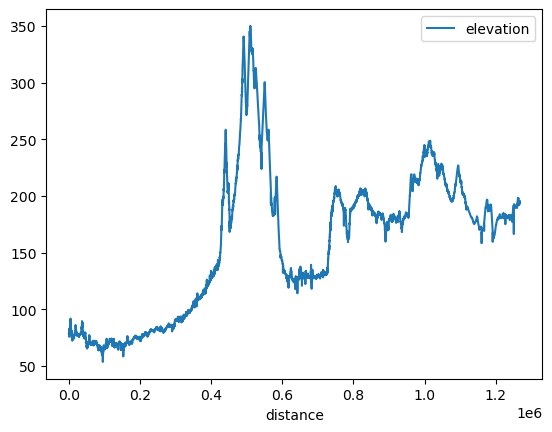

In [46]:
seg_df.plot(x="distance", y="elevation")

<Axes: xlabel='distance'>

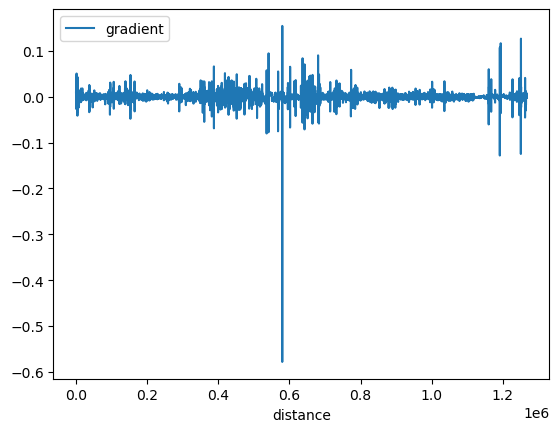

In [47]:
seg_df.plot(x="distance", y="gradient")

There are some pretty obvious excursions from what is typically permitted for gradients here. As a result we will need to go through and spatially filter the data. We need to use a variation of the Savgol filter that can accomodate unequally spaced locations.

In [48]:
def savgol_nonuniform(x, y, window_length, polyorder, deriv=0):
    """
    Savitzky-Golay smoothing 1D filter

    :param x:
    :param y:
    :param window_length: the smoothing sample, e.g. window_length=2 for smoothing over 5 points
    :param polyorder: the degree of the local polynomial fit, e.g. polyorder=2 for a parabolic fit
    :param deriv: The order of the derivative to compute. This must be a nonnegative integer.
            The default is 0, which means to filter the data without differentiating.
    :return:
    """
    if type(x) is not np.array:
        x = np.array(x)
    if type(y) is not np.array:
        y = np.array(y)

    n = int((window_length - 1) / 2)

    if x.shape != y.shape:
        raise RuntimeError("x and y arrays are of different shape")
    if x.shape[0] < window_length:
        raise RuntimeError("not enough data to start the smoothing process")
    if 2 * n + 1 <= polyorder + 1:
        raise RuntimeError("need at least deg+1 points to make the polynomial")

    # smooth start and end data
    ysm = np.zeros(y.shape)
    for i in range(n):
        j = y.shape[0] - i - 1
        if deriv == 0:
            ysm[i] = y[i]
            ysm[j] = y[j]
        if deriv == 1:
            ysm[i] = (y[i] - y[i - 1]) / (x[i] - x[i - 1])
            ysm[j] = (y[j] - y[j - 1]) / (x[j] - x[j - 1])
        if deriv == 2:
            ysm[i] = (((y[i] - y[i - 1]) / (x[i] - x[i - 1])) - ((y[i - 1] - y[i - 2]) / (x[i - 1] - x[i - 2]))) / \
                     (x[i] - x[i - 1])
            ysm[j] = (((y[j] - y[j - 1]) / (x[j] - x[j - 1])) - ((y[j - 1] - y[j - 2]) / (x[j - 1] - x[j - 2]))) / \
                     (x[j] - x[j - 1])
        if deriv >= 3:
            raise NotImplementedError("derivatives >= 3 not implemented")

    m = 2 * n + 1  # the size of the filter window
    o = polyorder + 1  # the smoothing order
    A = np.zeros((m, o))  # A matrix
    t = np.zeros(m)
    # start smoothing
    for i in range(n, x.shape[0] - n):
        for j in range(m):
            t[j] = x[i + j - n] - x[i]
        for j in range(m):
            r = 1.0
            for k in range(o):
                A[j, k] = r
                r *= t[j]
        tA = A.transpose()  # A transposed
        tAA = np.matmul(tA, A)  # make tA.A
        tAA = np.linalg.inv(tAA)  # make (tA.A)-¹ in place
        tAAtA = np.matmul(tAA, tA)  # make (tA.A)-¹.tA

        # compute the polynomial's value at the center of the sample
        ysm[i] = 0.0
        for j in range(m):
            ysm[i] += tAAtA[deriv, j] * y[i + j - n]

    return ysm

In [49]:
x=np.insert(np.array(seg_df['distance']),0,0.0,axis=0)

In [50]:
y=np.insert(np.array(seg_df['elevation']),0, start_elevation, axis=0)

In [51]:
new_elevations = savgol_nonuniform(x,y, 27, 3, 0)
seg_df['new_elevations']=new_elevations[1:]

<Axes: xlabel='distance'>

<Figure size 1600x800 with 0 Axes>

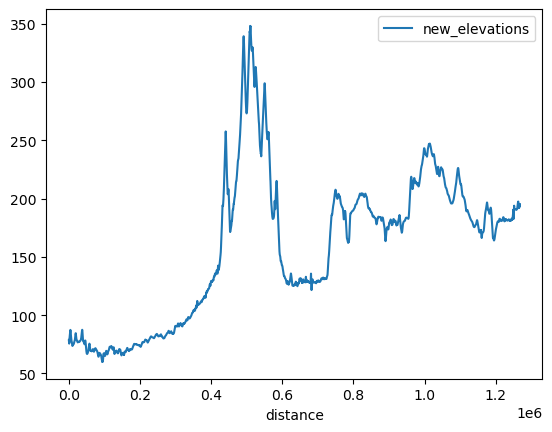

In [52]:
plt.figure(figsize=(16, 8))
seg_df.plot(x="distance", y=["new_elevations"])

<Axes: xlabel='distance'>

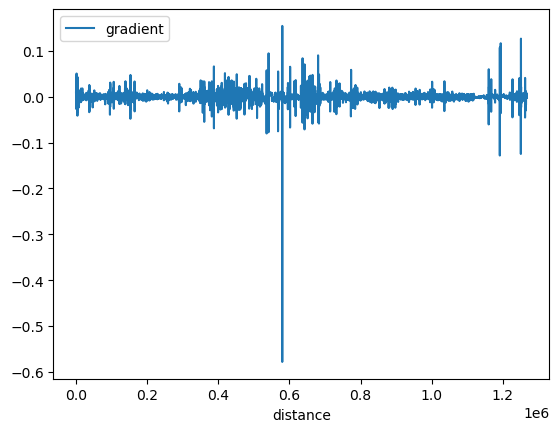

In [53]:
seg_df.plot(x="distance", y="gradient")

<Axes: xlabel='distance'>

<Figure size 1600x800 with 0 Axes>

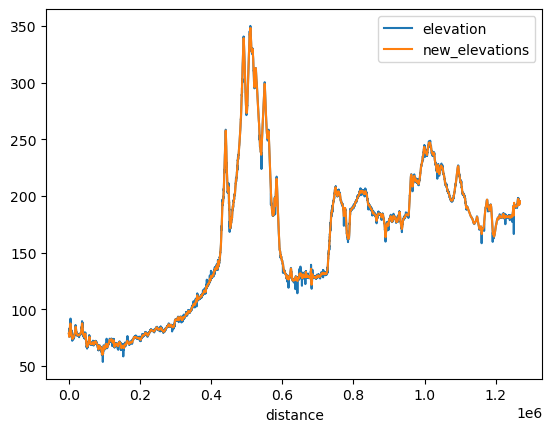

In [55]:
plt.figure(figsize=(16, 8))
seg_df.plot(x="distance", y=["elevation","new_elevations"])

In [76]:
subseg_df = seg_df.iloc[-550:-1]

<Axes: xlabel='distance'>

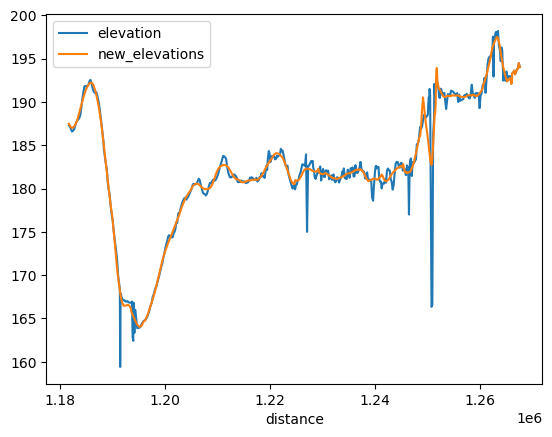

In [77]:
subseg_df.plot(x="distance", y=["elevation","new_elevations"])

<Axes: xlabel='distance'>

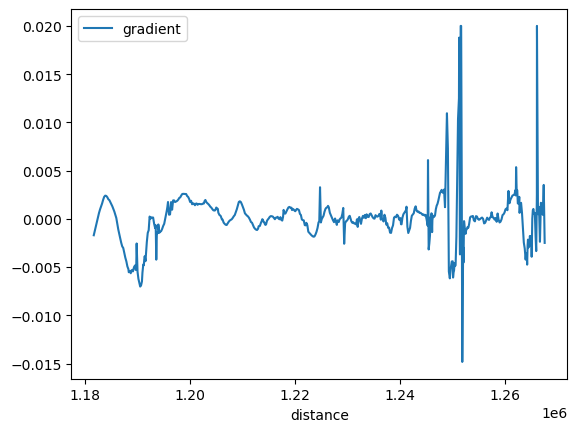

In [78]:
subseg_df.plot(x="distance", y="gradient")

In [79]:
delx = np.diff(x)
len(delx)

8035

In [80]:
dele = np.diff(new_elevations)
len(dele)

8035

In [81]:
temp=delx-np.array(seg_df['length'])
temp.sum()

-2.220215122861191e-09

In [82]:
grads = np.divide(dele, delx)

In [83]:
grads.max()

0.05164787156027958

In [84]:
seg_df.gradient=grads

<Axes: xlabel='distance'>

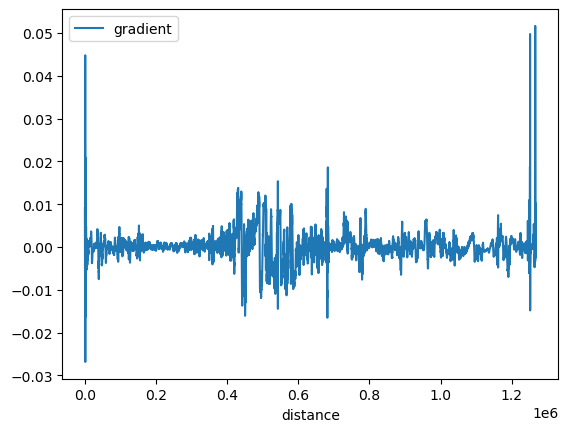

In [85]:
seg_df.plot(x="distance", y="gradient")

This has helped reduce the large gradients seen in the orginal data, but it is still not good enough, as a result we will just cap the largest excursions from the filtered data to be within the standard limits of gradients 0.02.

Let's just go through and cap the gadients to be between -0.02 and 0.02.

In [86]:
seg_df.loc[seg_df.gradient<-0.02, 'gradient']=-0.02

In [87]:
seg_df.loc[seg_df.gradient>0.02, 'gradient']=0.02

<Axes: xlabel='distance'>

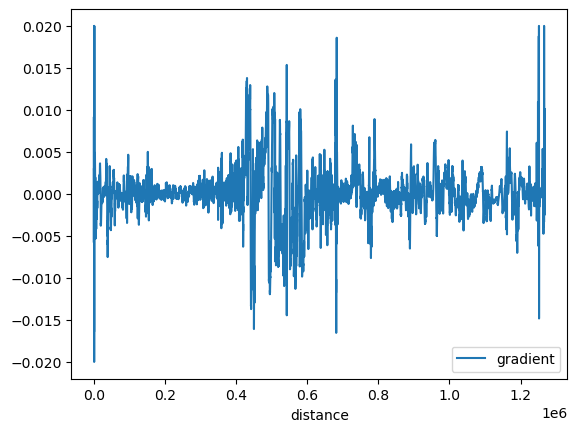

In [88]:
seg_df.plot(x="distance", y="gradient")

In [89]:
data={
    'route':19, 
    'elevations': new_elevations,
    'gradients': list(seg_df['gradient'])
}

In [90]:
URL11 = URL + "/api/something/stupid/"

In [91]:
res = requests.post(URL11, data=data, auth=TokenAuth(token))

In [92]:
res.status_code

200

In [93]:
response = requests.get(URL8+'19', auth=TokenAuth(token))
print(response.status_code)
segments=response.json()['results']['segments']
start_elevation = response.json()['results']['start_elevation']
seg_df2 = pd.DataFrame(segments)

200


<Axes: xlabel='distance'>

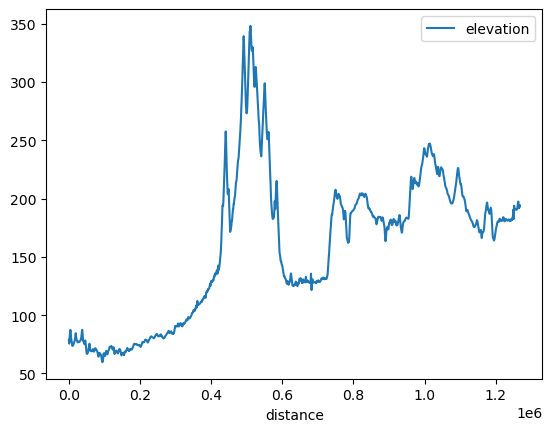

In [94]:
seg_df2.plot(x="distance", y="elevation")

<Axes: xlabel='distance'>

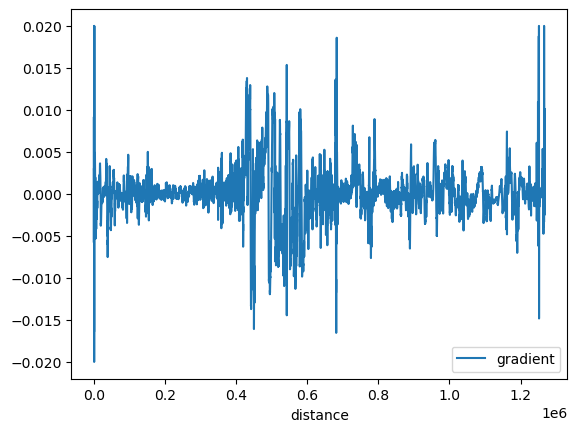

In [95]:
seg_df2.plot(x="distance", y="gradient")

We want to add the reverse route to the database.

In [96]:
gb2_nlr_route = {
    'origin': 18,
    'destination': 19,
    'owner': 7,
    'path': list(np.array(route)[::-1])
}

In [97]:
res = requests.post(URL5, data=gb2_nlr_route, auth=TokenAuth(token))
res.json()

{'results': 20}